In [1]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 986.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinu

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
from PIL import Image
import zipfile
import torch
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
from facenet_pytorch import InceptionResnetV1

Mounted at /content/drive


In [2]:
# Path to the zip file in Google Drive
zip_path = '/content/drive/My Drive/train.zip'

# Update the extract directory to /content/train
extract_dir = '/content/train'

# Path to the image directory
image_dir = os.path.join(extract_dir, 'train')

# Verify the image directory exists
if os.path.exists(image_dir):
    print("Image directory exists.")
    print("Files in the image directory:")
    print(os.listdir(image_dir)[:10])  # List the first 10 files in the directory
else:
    # Extract the contents of the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Extracted files to: {extract_dir}")

Extracted files to: /content/train


In [4]:
# Load the CSV file
labels_csv = '/content/fairface_label_train.csv'
df = pd.read_csv(labels_csv)
df = df.head(3000)

In [5]:
# Create full file paths
image_dir = '/content/train'
df['file_path'] = df['file'].apply(lambda x: os.path.join(image_dir, x))

In [6]:
# Encode race labels
race_encoder = LabelEncoder()
df['race_encoded'] = race_encoder.fit_transform(df['race'])

In [7]:
# Preprocess the images to the format required by VGG-Face
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG-Face input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    return transform(image)

In [9]:
# Apply preprocessing to all images and store the original images
df['image_tensor'] = df['file_path'].apply(lambda x: preprocess_image(x))
df['original_image'] = df['file_path'].apply(lambda x: Image.open(x).resize((224, 224)))


In [10]:
# Load the VGG-Face model
model = InceptionResnetV1(pretrained='vggface2').eval()


#Extract Embeddings allows for VGG to extract high-level features from the images and reduce the dimensionality of the data
def extract_embeddings(image_tensor):
    with torch.no_grad():
        embedding = model(image_tensor.unsqueeze(0))
    return embedding.squeeze().cpu().numpy()

# Extract embeddings for all images
df['embeddings'] = df['image_tensor'].apply(lambda x: extract_embeddings(x))


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [11]:
# Split the data into training and testing sets
X = np.vstack(df['embeddings'].values) #np.vstack vertically stacks array
y = df['race_encoded'].values
images = df['original_image'].values  # Storing the original images

X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(X, y, images, test_size=0.2, random_state=42)

class_labels = np.unique(y_train)

In [12]:
# Train an SVM classifier
classifier = SVC(kernel='linear', probability=True)
classifier.fit(X_train, y_train)

# Evaluate the classifier
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 52.50%


In [20]:
from sklearn.metrics import precision_score

# Predict on the training data to calculate precision for each class
y_test_pred = classifier.predict(X_test)

# Calculate precision for each class
precision = precision_score(y_test, y_test_pred, average=None, labels= class_labels)

In [21]:
from sklearn.metrics import confusion_matrix

y_preds = classifier.predict(X_test)

# Generate a confusion matrix
cm = confusion_matrix(y_test, y_preds, labels=class_labels)

# Calculate accuracy for each label
label_accuracies = cm.diagonal() / cm.sum(axis=1)

for label, accuracy in zip(class_labels, label_accuracies):
    print(f'Accuracy for label {label}: {accuracy * 100:.2f}%')


Accuracy for label 0: 73.91%
Accuracy for label 1: 62.96%
Accuracy for label 2: 45.71%
Accuracy for label 3: 31.58%
Accuracy for label 4: 25.45%
Accuracy for label 5: 50.00%
Accuracy for label 6: 66.36%


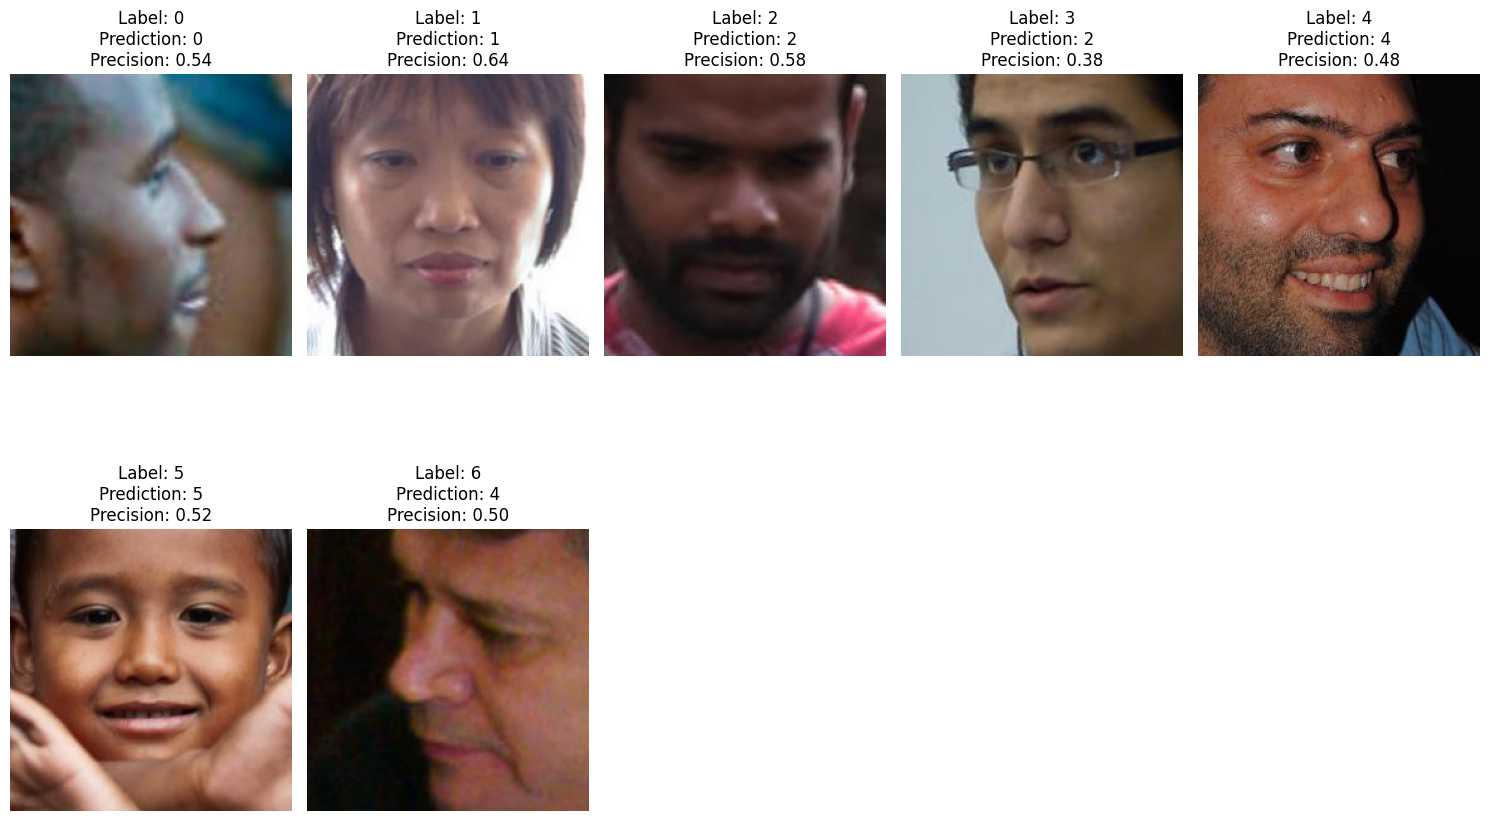

In [22]:
# Visualize the results
import matplotlib.pyplot as plt

class_labels = np.unique(y_train)

plt.figure(figsize=(15, 10))
for i, label in enumerate(class_labels):
    # Find the first image index with the current label
    image_index = np.where(y_train == label)[0][0]
    image = images_train[image_index]

    # Get the corresponding embedding
    embedding = X_train[image_index].reshape(1, -1)

    # Predict the label and probabilities
    prediction = classifier.predict(embedding)
    probabilities = classifier.predict_proba(embedding)

    # Plot the image and prediction precision
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(f'Label: {label}\nPrediction: {prediction[0]}\nPrecision: {precision[i]:.2f}')
    plt.axis('off')

plt.tight_layout()
plt.show()
